В этом ноутбуке будем работать с моделями из репозитория [pyod](https://github.com/yzhao062/pyod), которые позиционируют себя как "comprehensive and scalable python toolkit for detecting outlying objects in multivariate data". В библиотеке есть много разных моделей, но из тех что реализованы в нашем проекте, есть только autoencoder и variational autoencoder, поэтому будем сравнивать их по метрикам и времени обучения на [SWAT](https://itrust.sutd.edu.sg/itrust-labs_datasets/dataset_info/) и [SKAB](https://github.com/waico/SKAB) датасетах.

In [ ]:
! pip install pyod 

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from typing import Dict

import warnings
warnings.filterwarnings("ignore")

### Seed fixation

In [3]:
seed_value = 42

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

# SWAT dataset

### Data processing

In [4]:
df = pd.read_excel("../data/SWAT.xlsx")
df.head()

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,28/12/2015 7:50:00 AM,2.462287,541.3740,2,1,1,260.7344,8.409895,324.8398,0.000513,...,2,1,251.4580,1.297536,190.1436,0.000064,1,1,1,Normal
1,28/12/2015 7:50:01 AM,2.441469,541.4918,2,1,1,260.7344,8.412138,324.3015,0.000256,...,2,1,251.4580,1.297536,190.1436,0.000064,1,1,1,Normal
2,28/12/2015 7:50:02 AM,2.428338,541.2955,2,1,1,260.7344,8.414701,323.7888,0.000256,...,2,1,251.4580,1.297536,190.1436,0.000064,1,1,1,Normal
3,28/12/2015 7:50:03 AM,2.425776,542.5124,2,1,1,260.7344,8.420149,323.3530,0.000256,...,2,1,251.4580,1.441707,190.1436,0.000064,1,1,1,Normal
4,28/12/2015 7:50:04 AM,2.424174,542.7871,2,1,1,260.7344,8.423674,322.8916,0.000256,...,2,1,251.2817,1.441707,190.1436,0.000064,1,1,1,Normal


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18663 entries, 0 to 18662
Data columns (total 53 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0    Timestamp     18663 non-null  object 
 1   FIT101         18663 non-null  float64
 2   LIT101         18663 non-null  float64
 3   MV101          18663 non-null  int64  
 4   P101           18663 non-null  int64  
 5   P102           18663 non-null  int64  
 6    AIT201        18663 non-null  float64
 7   AIT202         18663 non-null  float64
 8   AIT203         18663 non-null  float64
 9   FIT201         18663 non-null  float64
 10   MV201         18663 non-null  int64  
 11   P201          18663 non-null  int64  
 12   P202          18663 non-null  int64  
 13  P203           18663 non-null  int64  
 14   P204          18663 non-null  int64  
 15  P205           18663 non-null  int64  
 16  P206           18663 non-null  int64  
 17  DPIT301        18663 non-null  float64
 18  FIT301

Вектор Normal/Attack указывает на то, являются ли наблюдения аномальными

In [6]:
df['Normal/Attack'].replace({'Normal':0, 'Attack':1}, inplace=True)
df["anomaly"] = df["Normal/Attack"]

anomaly = df.anomaly
df.drop(["Normal/Attack"], axis=1, inplace=True)

In [7]:
important_features = [
    'LIT101', 'MV301', 'MV302', ' MV303', 'MV304', 'P302', 'AIT401', 'AIT504', 'FIT504', 'PIT502', 'P602']

In [8]:
df = df[important_features]
df.head()

,LIT101,MV301,MV302,MV303,MV304,P302,AIT401,AIT504,FIT504,PIT502,P602
0,541.3740,1,1,1,1,1,148.808,12.03538,0.306761,1.297536,1
1,541.4918,1,1,1,1,1,148.808,12.03538,0.306761,1.297536,1
2,541.2955,1,1,1,1,1,148.808,12.03538,0.306761,1.297536,1
3,542.5124,1,1,1,1,1,148.808,12.03538,0.306761,1.441707,1
4,542.7871,1,1,1,1,1,148.808,12.03538,0.306761,1.441707,1


In [9]:
first_anomaly_index = anomaly[anomaly == 1].index[0]
train_size = int(first_anomaly_index * 0.8)

### Autoencoder prediction

In [10]:
from pyod.models.auto_encoder import AutoEncoder
from tensorflow.keras.losses import mean_absolute_error as mae

In [14]:
ae_params = {
    "hidden_neurons": [64, 32, 16, 8, 8, 16, 32, 64],
    "epochs": 10,
    "batch_size": 16,
    "loss": mae,
    "random_state": 42,
}

In [17]:
%%time
ae = AutoEncoder(**ae_params).fit(df[:train_size])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 11)                132       
                                                                 
 dropout_30 (Dropout)        (None, 11)                0         
                                                                 
 dense_34 (Dense)            (None, 11)                132       
                                                                 
 dropout_31 (Dropout)        (None, 11)                0         
                                                                 
 dense_35 (Dense)            (None, 64)                768       
                                                                 
 dropout_32 (Dropout)        (None, 64)                0         
                                                                 
 dense_36 (Dense)            (None, 32)               

In [18]:
%%time
r = pd.Series(ae.decision_function(df[train_size:]))
prediction = (r > r.quantile(0.75) + 1.5 * (r.quantile(0.75) - r.quantile(0.25))).values

CPU times: user 647 ms, sys: 19.9 ms, total: 667 ms
Wall time: 561 ms


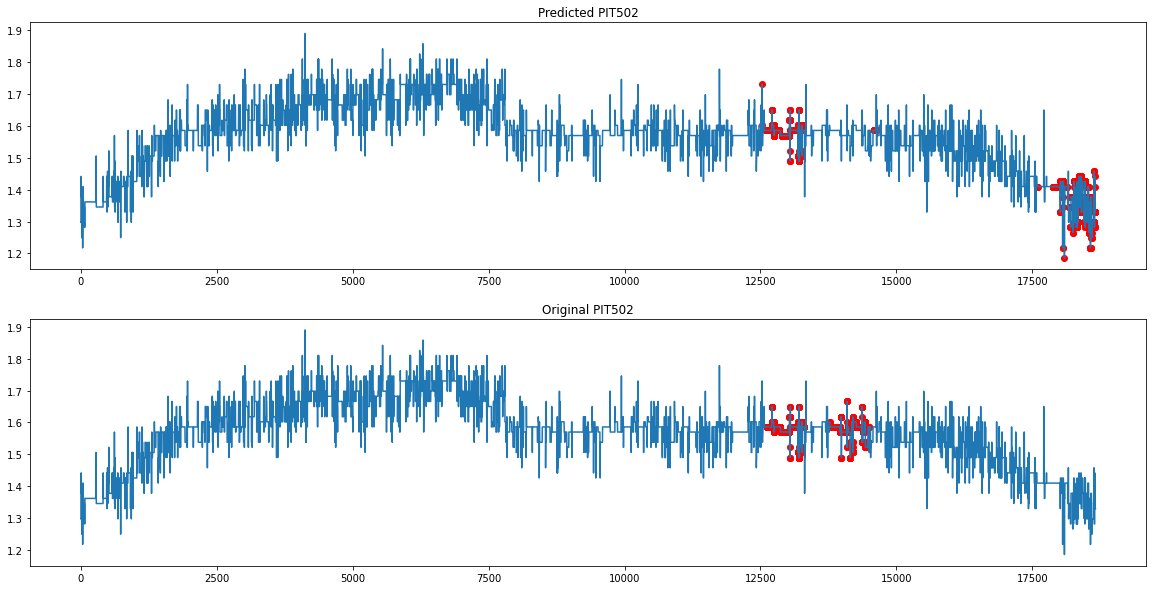

In [19]:
p = "PIT502"

fig, axs = plt.subplots(2, 1, figsize=(20,10))
p_data = df[p]
axs[0].plot(p_data)
axs[1].plot(p_data)

y = pd.Series(prediction, index=df[train_size:].index)
anomalies_indecies = y.index[y == 1]
axs[0].scatter(anomalies_indecies, p_data[anomalies_indecies], color='r')
axs[0].set_title(f"Predicted {p}")

y = pd.Series(anomaly)
anomalies_indecies = pd.Series(y.values).index[y == 1]
axs[1].scatter(df.index[anomalies_indecies], p_data[anomalies_indecies], color='r')
axs[1].set_title(f"Original {p}")

plt.show()

In [38]:
def f1_score(test, pred):
    p=pred.values.astype(bool)
    t=test.values.astype(bool)
    tp = (p & t).sum()
    fp = (p & ~t).sum()
    fn = (~p & t).sum()
    return tp / (tp + 0.5 * (fp + fn))

def mar(test, pred):
    p = pred.values.astype(bool)
    t = test.values.astype(bool)
    fn = (~p & t).sum()
    tp = (p & t).sum()
    return fn / (tp + fn)

def far(test, pred):
    p=pred.values.astype(bool)
    t=test.values.astype(bool)
    fp = (p & ~t).sum()
    tn = (~p & ~t).sum()
    return fp / (fp + tn)

In [21]:
print(f"F1 = {round(f1_score(pd.Series(prediction), anomaly[train_size:]), 2)}")

F1 = 0.44


### Variational autoencoder prediction

In [22]:
from pyod.models.vae import VAE

In [23]:
vae_params = {
    "encoder_neurons": [64, 32, 16, 8],
    "decoder_neurons": [16, 32, 64, 8],
    "latent_dim": 8,
    "epochs": 10,
    "batch_size": 16,
    "loss": mae,
    "random_state": 42,
}

In [24]:
%%time
vae = VAE(**vae_params).fit(df[:train_size])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 11)]         0           []                               
                                                                                                  
 dense_44 (Dense)               (None, 11)           132         ['input_1[0][0]']                
                                                                                                  
 dense_45 (Dense)               (None, 64)           768         ['dense_44[0][0]']               
                                                                                                  
 dropout_40 (Dropout)           (None, 64)           0           ['dense_45[0][0]']               
                                                                                              

568/568 [==============================] - 8s 7ms/step - loss: 6.5148 - val_loss: 5.5319
Epoch 2/10
568/568 [==============================] - 3s 6ms/step - loss: 5.5245 - val_loss: 5.4646
Epoch 3/10
568/568 [==============================] - 3s 5ms/step - loss: 5.4776 - val_loss: 5.4508
Epoch 4/10
568/568 [==============================] - 3s 5ms/step - loss: 5.4689 - val_loss: 5.4428
Epoch 5/10
568/568 [==============================] - 3s 5ms/step - loss: 5.4590 - val_loss: 5.4433
Epoch 6/10
568/568 [==============================] - 3s 5ms/step - loss: 5.4497 - val_loss: 5.4452
Epoch 7/10
568/568 [==============================] - 3s 5ms/step - loss: 5.4346 - val_loss: 5.4381
Epoch 8/10
568/568 [==============================] - 3s 5ms/step - loss: 5.4135 - val_loss: 5.4360
Epoch 9/10
568/568 [==============================] - 3s 5ms/step - loss: 5.4096 - val_loss: 5.4361
Epoch 10/10
568/568 [==============================] - 3s 5ms/step - loss: 5.3957 - val_loss: 5.4344
CPU times:

In [25]:
%%time
r = pd.Series(vae.decision_function(df[train_size:]))
prediction = (r > r.quantile(0.75) + 1.5 * (r.quantile(0.75) - r.quantile(0.25))).values

CPU times: user 674 ms, sys: 42.5 ms, total: 716 ms
Wall time: 599 ms


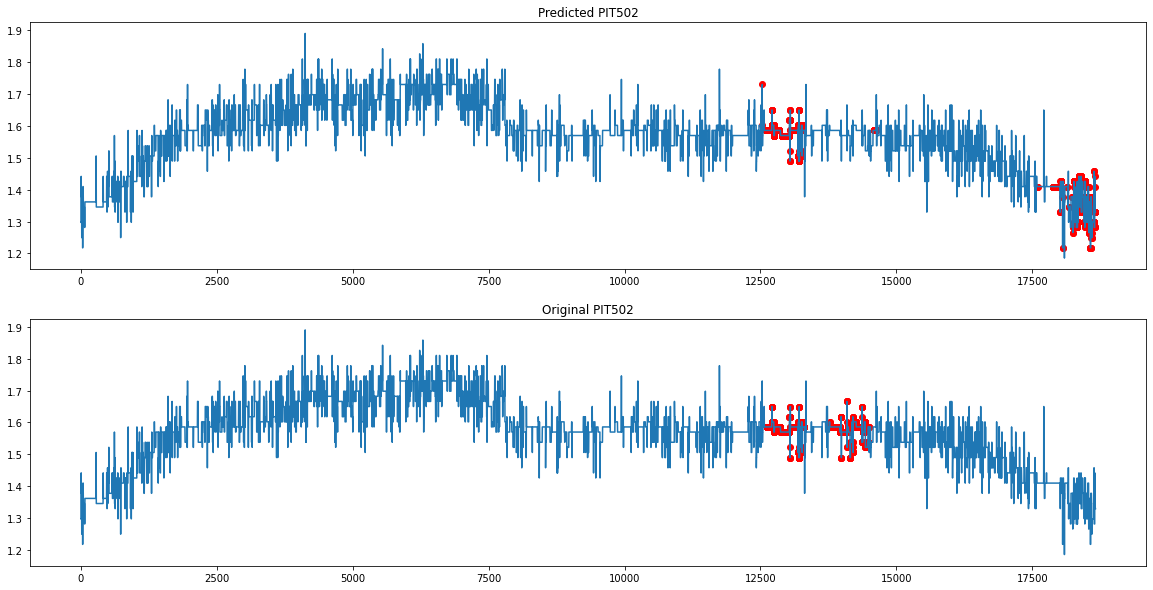

In [26]:
p = "PIT502"

fig, axs = plt.subplots(2, 1, figsize=(20,10))
p_data = df[p]
axs[0].plot(p_data)
axs[1].plot(p_data)

y = pd.Series(prediction, index=df[train_size:].index)
anomalies_indecies = y.index[y == 1]
axs[0].scatter(anomalies_indecies, p_data[anomalies_indecies], color='r')
axs[0].set_title(f"Predicted {p}")

y = pd.Series(anomaly)
anomalies_indecies = pd.Series(y.values).index[y == 1]
axs[1].scatter(df.index[anomalies_indecies], p_data[anomalies_indecies], color='r')
axs[1].set_title(f"Original {p}")

plt.show()

In [27]:
print(f"F1 = {round(f1_score(pd.Series(prediction), anomaly[train_size:]), 2)}")

F1 = 0.46


# SKAB dataset

### Load & process data

In [28]:
df_train = pd.read_csv("../data/valve1/6.csv", sep=";", index_col="datetime", parse_dates=True)
df_train.head()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-09 12:14:36,0.027429,0.040353,0.770310,0.382638,71.2129,25.0827,219.789,32.0000,0.0,0.0
2020-03-09 12:14:37,0.027269,0.040226,1.096960,0.710565,71.4284,25.0863,233.117,32.0104,0.0,0.0
2020-03-09 12:14:38,0.027040,0.039773,1.140150,0.054711,71.3468,25.0874,234.745,32.0000,0.0,0.0
2020-03-09 12:14:39,0.027563,0.040313,1.108680,-0.273216,71.3258,25.0897,205.254,32.0104,0.0,0.0
2020-03-09 12:14:41,0.026570,0.039566,0.704404,0.382638,71.2725,25.0831,212.095,33.0000,0.0,0.0


In [29]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1154 entries, 2020-03-09 12:14:36 to 2020-03-09 12:34:35
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Accelerometer1RMS    1154 non-null   float64
 1   Accelerometer2RMS    1154 non-null   float64
 2   Current              1154 non-null   float64
 3   Pressure             1154 non-null   float64
 4   Temperature          1154 non-null   float64
 5   Thermocouple         1154 non-null   float64
 6   Voltage              1154 non-null   float64
 7   Volume Flow RateRMS  1154 non-null   float64
 8   anomaly              1154 non-null   float64
 9   changepoint          1154 non-null   float64
dtypes: float64(10)
memory usage: 99.2 KB


In [30]:
first_anomaly_index = df_train.index.get_loc(df_train[df_train.anomaly == 1].index[0])
train_size = int(first_anomaly_index * 0.8)

In [31]:
important_features = ['Volume Flow RateRMS', 'Temperature', 'Pressure', ]
anomaly = df_train.anomaly

df_train = df_train[important_features]
df_train.head()

,Volume Flow RateRMS,Temperature,Pressure
datetime,,,
2020-03-09 12:14:36,32.0000,71.2129,0.382638
2020-03-09 12:14:37,32.0104,71.4284,0.710565
2020-03-09 12:14:38,32.0000,71.3468,0.054711
2020-03-09 12:14:39,32.0104,71.3258,-0.273216
2020-03-09 12:14:41,33.0000,71.2725,0.382638


### Autoencoder prediction

In [32]:
print("\n".join(map(lambda x: f"{x} {ae_params[x]}", ae_params)))

hidden_neurons [64, 32, 16, 8, 8, 16, 32, 64]
epochs 10
batch_size 16
loss <function mean_absolute_error at 0x7f2900e758b0>
random_state 42


In [33]:
ae_params["hidden_neurons"] = [64, 32, 8, 2, 2, 8, 32, 64]
ae_params["batch_size"] = 4

class AutoencoderPredictor:
    def fit(self, df_train, **params):
        self.model = AutoEncoder(**params).fit(df_train)
        
    def predict(self, dfs_test: Dict[str, pd.DataFrame]) -> Dict[str, pd.Series]:
        predictions = {}
        for file_name, df in dfs_test.items():
            y_test = df.anomaly
            df = df[important_features]
            r = pd.Series(self.model.decision_function(df), index=df.index)
            
            smoothed = r.rolling(window = 10).mean().fillna(r.iloc[0])
            diff = smoothed.diff(10).abs()

            IQR = diff.quantile(0.75) - diff.quantile(0.75)
            UCL = diff.quantile(0.75) + 1.5 * IQR

            s = diff > UCL
            is_anomaly = s.rolling(window = 10).mean().fillna(s.iloc[0])

            anomalous_data_indices = pd.Series(is_anomaly.index[is_anomaly > 0])
            prediction = pd.Series(data=0, index=df.index)
            prediction[anomalous_data_indices] = 1
            predictions[file_name] = prediction
            
        return predictions

In [34]:
%%time
ae = AutoencoderPredictor()
ae.fit(df_train[:train_size], **ae_params)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 3)                 12        
                                                                 
 dropout_48 (Dropout)        (None, 3)                 0         
                                                                 
 dense_58 (Dense)            (None, 3)                 12        
                                                                 
 dropout_49 (Dropout)        (None, 3)                 0         
                                                                 
 dense_59 (Dense)            (None, 64)                256       
                                                                 
 dropout_50 (Dropout)        (None, 64)                0         
                                                                 
 dense_60 (Dense)            (None, 32)               

In [36]:
%%time
from loader import load_df_by_names

df_by_names = load_df_by_names("../data/", ["valve1", "valve2"])
y_test_by_names = {name: df.anomaly for name, df in df_by_names.items()}
predictions_by_names = ae.predict(df_by_names)

CPU times: user 2.96 s, sys: 133 ms, total: 3.09 s
Wall time: 2.93 s


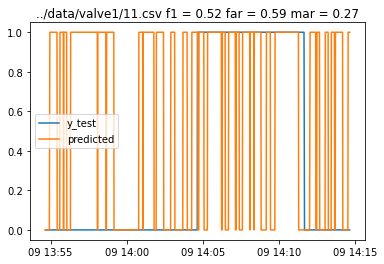

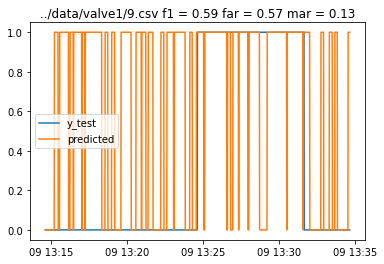

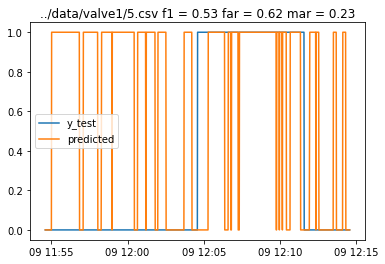

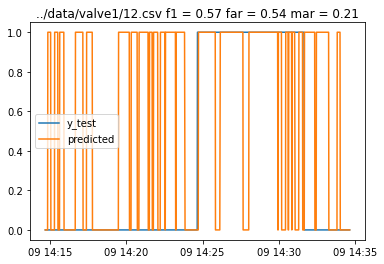

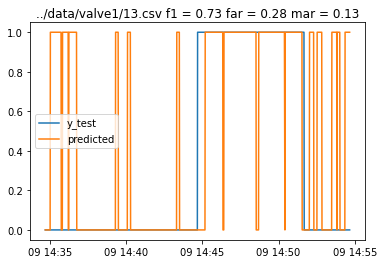

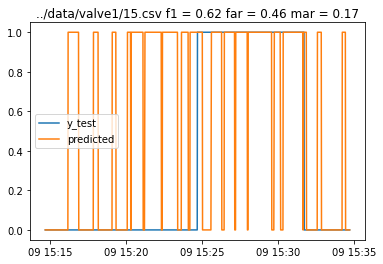

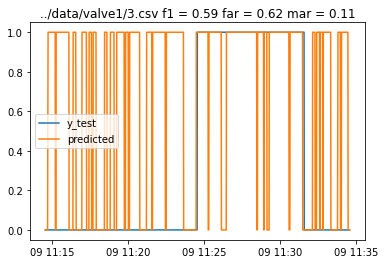

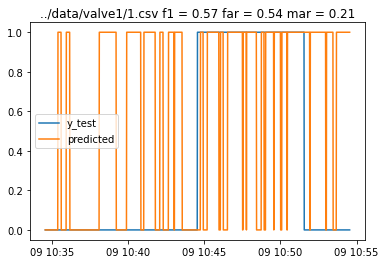

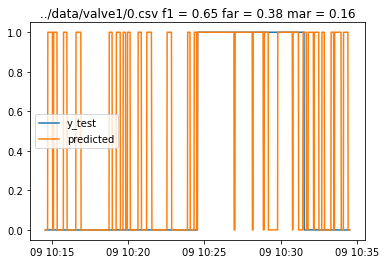

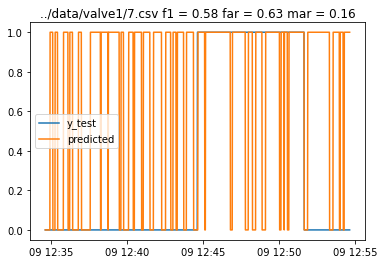

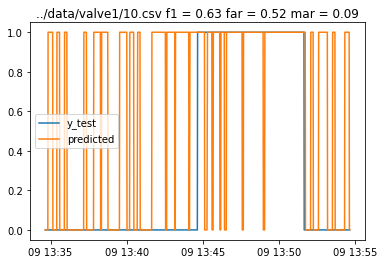

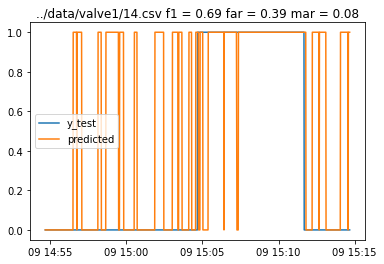

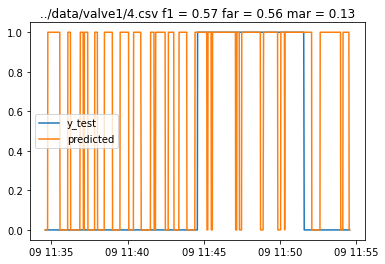

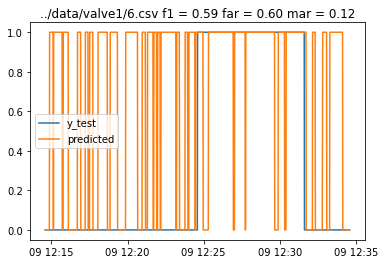

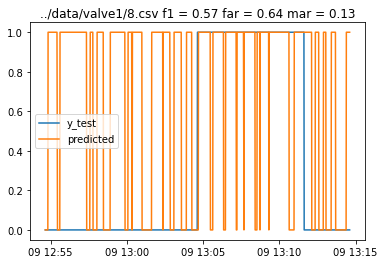

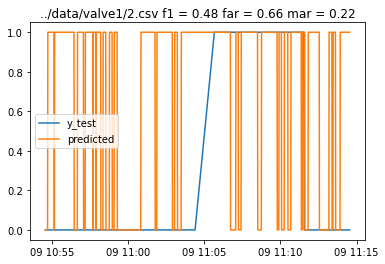

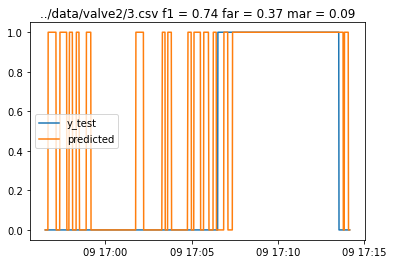

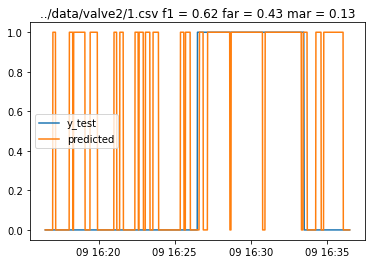

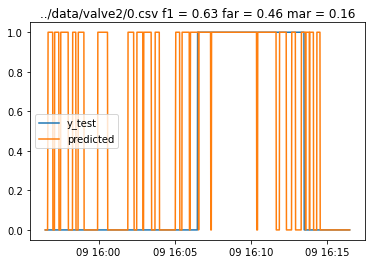

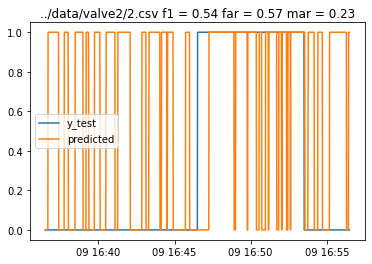

In [39]:
metrics= {}
predictions = []

draw = 1

all_prediction = {"valve1":[], "valve2":[]}
all_test = {"valve1":[], "valve2":[]}

for file_name, prediction in predictions_by_names.items():
    y_test = y_test_by_names[file_name]
    f1 = f1_score(y_test, prediction)
    far_score = far(y_test, prediction)
    mar_score = mar(y_test, prediction)
    for i in [1,2]:
        if f"valve{i}" in file_name:
            all_prediction[f"valve{i}"].append(prediction)
            all_test[f"valve{i}"].append(y_test)
            
    metrics[file_name[7:]] = (f1, far_score, mar_score)
    
    if draw:
        title = file_name + " f1 = {:3.2f} far = {:3.2f} mar = {:3.2f}".format(f1, far_score, mar_score)
        plt.title(title)
        plt.plot(y_test)    
        plt.plot(prediction)
        plt.legend(["y_test", "predicted"])
        plt.show()

        
grouped_metrics = {}
for group in (g for g in all_prediction if all_prediction[g]):    
    prc = pd.concat(all_prediction[group])
    tc = pd.concat(all_test[group])
    total_f1 = f1_score(tc, prc)
    total_far = far(tc, prc)
    total_mar = mar(tc, prc)
    grouped_metrics[group] = (total_f1, total_far, total_mar)

In [41]:
from IPython.display import display, Markdown, Latex

def show_score_table(metrics:dict) -> None:
    columns = list(metrics.keys())
    metrics_arr = np.array(list(metrics.values()))
    metric_names = ["F1", "FAR", "MAR"]
    table = []
    table.append(" | ".join(["metric"] + columns))
    table.append(" | ".join(["---" for _ in range(len(columns) + 1)]))
    for i in range(metrics_arr.shape[-1]):
        row = metrics_arr[:, i]
        table.append(f"{metric_names[i]} |" + " | ".join(map(lambda x: str(round(x, 2)), row)))
    table_str = "\n".join(table)    
    display(Markdown(table_str))

show_score_table(metrics)

show_score_table(grouped_metrics)

metric | /valve1/11.csv | /valve1/9.csv | /valve1/5.csv | /valve1/12.csv | /valve1/13.csv | /valve1/15.csv | /valve1/3.csv | /valve1/1.csv | /valve1/0.csv | /valve1/7.csv | /valve1/10.csv | /valve1/14.csv | /valve1/4.csv | /valve1/6.csv | /valve1/8.csv | /valve1/2.csv | /valve2/3.csv | /valve2/1.csv | /valve2/0.csv | /valve2/2.csv
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
F1 |0.52 | 0.59 | 0.53 | 0.57 | 0.73 | 0.62 | 0.59 | 0.57 | 0.65 | 0.58 | 0.63 | 0.69 | 0.57 | 0.59 | 0.57 | 0.48 | 0.74 | 0.62 | 0.63 | 0.54
FAR |0.59 | 0.57 | 0.62 | 0.54 | 0.28 | 0.46 | 0.62 | 0.54 | 0.38 | 0.63 | 0.52 | 0.39 | 0.56 | 0.6 | 0.64 | 0.66 | 0.37 | 0.43 | 0.46 | 0.57
MAR |0.27 | 0.13 | 0.23 | 0.21 | 0.13 | 0.17 | 0.11 | 0.21 | 0.16 | 0.16 | 0.09 | 0.08 | 0.13 | 0.12 | 0.13 | 0.22 | 0.09 | 0.13 | 0.16 | 0.23

metric | valve1 | valve2
--- | --- | ---
F1 |0.59 | 0.63
FAR |0.54 | 0.46
MAR |0.16 | 0.15

### Variational autoencoder prediction

In [42]:
print("\n".join(map(lambda x: f"{x} {vae_params[x]}", vae_params)))

encoder_neurons [64, 32, 16, 8]
decoder_neurons [16, 32, 64, 8]
latent_dim 8
epochs 10
batch_size 16
loss <function mean_absolute_error at 0x7f2900e758b0>
random_state 42


In [43]:
vae_params["encoder_neurons"] = [64, 32, 16, 8, 4, 2]
vae_params["decoder_neurons"] = [2, 4, 8, 16, 32, 64]
vae_params["latent_dim"] = 2
vae_params["batch_size"] = 4

class VAEPredictor:
    def fit(self, df_train, **params):
        self.model = VAE(**params).fit(df_train)
        
    def predict(self, dfs_test: Dict[str, pd.DataFrame]) -> Dict[str, pd.Series]:
        predictions = {}
        for file_name, df in dfs_test.items():
            y_test = df.anomaly
            df = df[important_features]
            r = pd.Series(self.model.decision_function(df), index=df.index)
            
            smoothed = r.rolling(window = 10).mean().fillna(r.iloc[0])
            diff = smoothed.diff(10).abs()

            IQR = diff.quantile(0.75) - diff.quantile(0.75)
            UCL = diff.quantile(0.75) + 1.5 * IQR

            s = diff > UCL
            is_anomaly = s.rolling(window = 10).mean().fillna(s.iloc[0])

            anomalous_data_indices = pd.Series(is_anomaly.index[is_anomaly > 0])
            prediction = pd.Series(data=0, index=df.index)
            prediction[anomalous_data_indices] = 1
            predictions[file_name] = prediction
            
        return predictions

In [44]:
%%time
vae = VAEPredictor()
vae.fit(df_train[:train_size], **vae_params)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 dense_68 (Dense)               (None, 3)            12          ['input_3[0][0]']                
                                                                                                  
 dense_69 (Dense)               (None, 64)           256         ['dense_68[0][0]']               
                                                                                                  
 dropout_58 (Dropout)           (None, 64)           0           ['dense_69[0][0]']               
                                                                                            

104/104 [==============================] - 6s 12ms/step - loss: 3.1242 - val_loss: 2.8244
Epoch 2/10
104/104 [==============================] - 1s 9ms/step - loss: 2.6536 - val_loss: 2.5567
Epoch 3/10
104/104 [==============================] - 1s 5ms/step - loss: 2.5449 - val_loss: 2.5381
Epoch 4/10
104/104 [==============================] - 1s 10ms/step - loss: 2.5247 - val_loss: 2.5296
Epoch 5/10
104/104 [==============================] - 1s 6ms/step - loss: 2.5160 - val_loss: 2.5365
Epoch 6/10
104/104 [==============================] - 1s 11ms/step - loss: 2.5109 - val_loss: 2.5359
Epoch 7/10
104/104 [==============================] - 1s 7ms/step - loss: 2.5181 - val_loss: 2.5401
Epoch 8/10
104/104 [==============================] - 1s 9ms/step - loss: 2.5077 - val_loss: 2.5333
Epoch 9/10
104/104 [==============================] - 1s 7ms/step - loss: 2.5078 - val_loss: 2.5340
Epoch 10/10
104/104 [==============================] - 1s 5ms/step - loss: 2.5040 - val_loss: 2.5372
CPU tim

In [45]:
%%time
df_by_names = load_df_by_names("../data/", ["valve1", "valve2"])
y_test_by_names = {name: df.anomaly for name, df in df_by_names.items()}
predictions_by_names = vae.predict(df_by_names)

CPU times: user 3.48 s, sys: 150 ms, total: 3.63 s
Wall time: 3.43 s


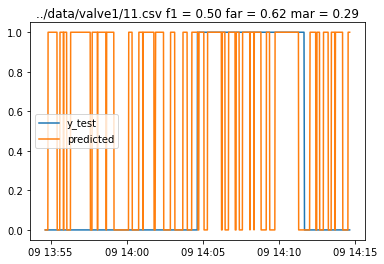

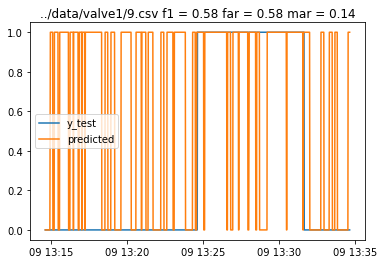

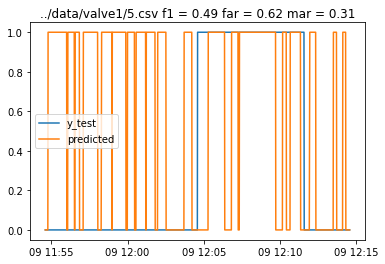

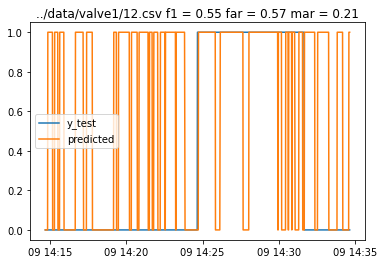

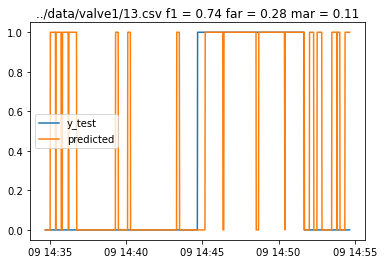

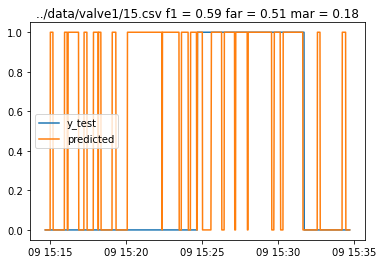

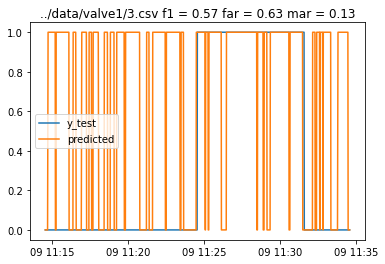

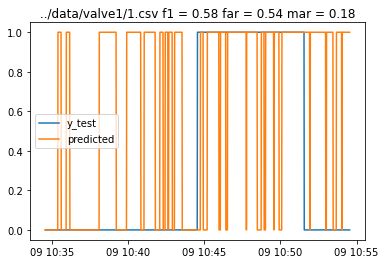

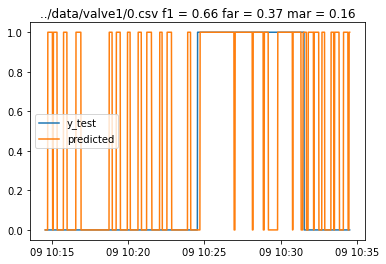

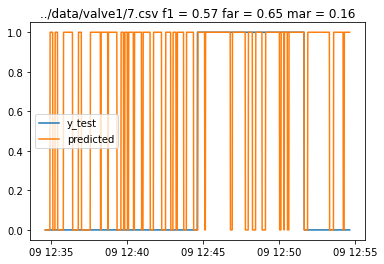

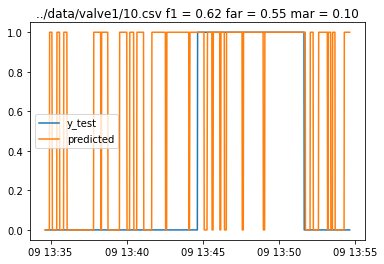

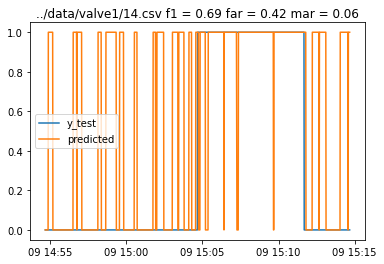

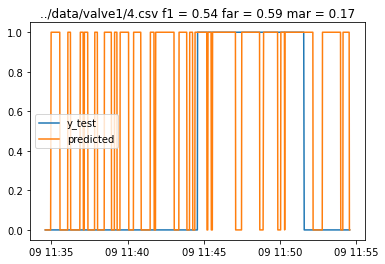

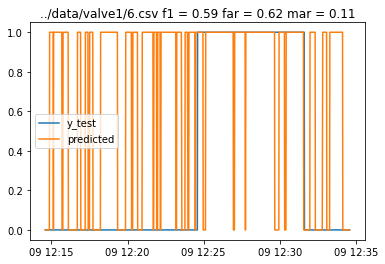

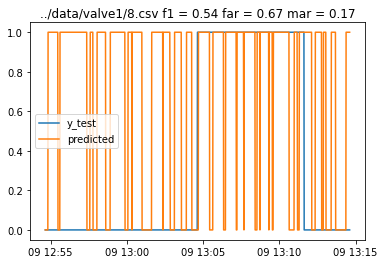

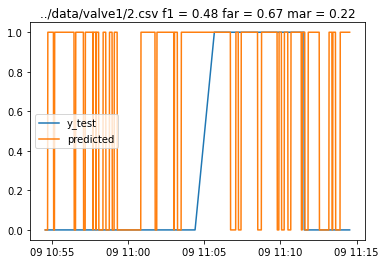

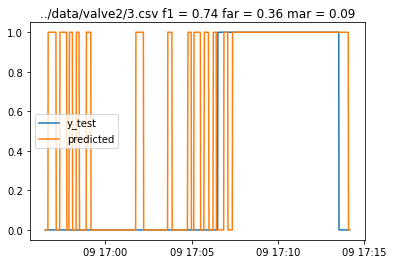

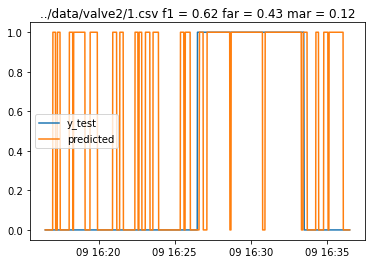

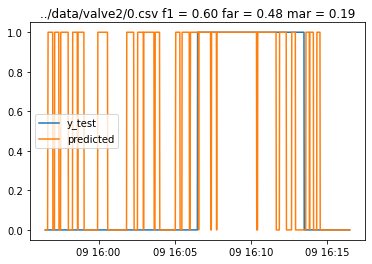

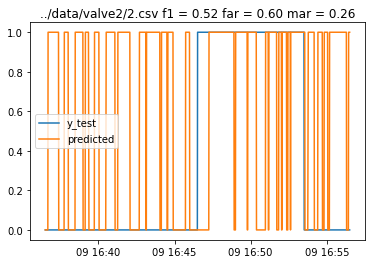

In [46]:
metrics= {}
predictions = []

draw = 1

all_prediction = {"valve1":[], "valve2":[]}
all_test = {"valve1":[], "valve2":[]}

for file_name, prediction in predictions_by_names.items():
    y_test = y_test_by_names[file_name]
    f1 = f1_score(y_test, prediction)
    far_score = far(y_test, prediction)
    mar_score = mar(y_test, prediction)
    for i in [1,2]:
        if f"valve{i}" in file_name:
            all_prediction[f"valve{i}"].append(prediction)
            all_test[f"valve{i}"].append(y_test)
            
    metrics[file_name[7:]] = (f1, far_score, mar_score)
    
    if draw:
        title = file_name + " f1 = {:3.2f} far = {:3.2f} mar = {:3.2f}".format(f1, far_score, mar_score)
        plt.title(title)
        plt.plot(y_test)    
        plt.plot(prediction)
        plt.legend(["y_test", "predicted"])
        plt.show()

        
grouped_metrics = {}
for group in (g for g in all_prediction if all_prediction[g]):    
    prc = pd.concat(all_prediction[group])
    tc = pd.concat(all_test[group])
    total_f1 = f1_score(tc, prc)
    total_far = far(tc, prc)
    total_mar = mar(tc, prc)
    grouped_metrics[group] = (total_f1, total_far, total_mar)

In [47]:
show_score_table(metrics)

show_score_table(grouped_metrics)

metric | /valve1/11.csv | /valve1/9.csv | /valve1/5.csv | /valve1/12.csv | /valve1/13.csv | /valve1/15.csv | /valve1/3.csv | /valve1/1.csv | /valve1/0.csv | /valve1/7.csv | /valve1/10.csv | /valve1/14.csv | /valve1/4.csv | /valve1/6.csv | /valve1/8.csv | /valve1/2.csv | /valve2/3.csv | /valve2/1.csv | /valve2/0.csv | /valve2/2.csv
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
F1 |0.5 | 0.58 | 0.49 | 0.55 | 0.74 | 0.59 | 0.57 | 0.58 | 0.66 | 0.57 | 0.62 | 0.69 | 0.54 | 0.59 | 0.54 | 0.48 | 0.74 | 0.62 | 0.6 | 0.52
FAR |0.62 | 0.58 | 0.62 | 0.57 | 0.28 | 0.51 | 0.63 | 0.54 | 0.37 | 0.65 | 0.55 | 0.42 | 0.59 | 0.62 | 0.67 | 0.67 | 0.36 | 0.43 | 0.48 | 0.6
MAR |0.29 | 0.14 | 0.31 | 0.21 | 0.11 | 0.18 | 0.13 | 0.18 | 0.16 | 0.16 | 0.1 | 0.06 | 0.17 | 0.11 | 0.16 | 0.22 | 0.09 | 0.12 | 0.19 | 0.26

metric | valve1 | valve2
--- | --- | ---
F1 |0.58 | 0.62
FAR |0.55 | 0.47
MAR |0.17 | 0.17

In [ ]:
tp / (tp + 0.5 * (fp + fn))

$$\large MAR = \frac{FN}{TP + FN}$$

$$\large FAR = \frac{FP}{FP + TN}$$


$$\large F1 = \frac{TP}{TP + 0.5 \space (FP + FN)}$$